> Get topics for each decade (folder-by-folder, basically)

Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim --user
# !pip install pyLDAvis --user

In [1]:
import re
import spacy
import gensim
import logging
import warnings
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from pprint import pprint
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader
from gensim.parsing.preprocessing import preprocess_string


%matplotlib inline
pyLDAvis.enable_notebook()
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/koko/system/anaconda/envs/python38/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


# Functions

In [2]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [3]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [4]:
# Setence to Words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    @param dictionary : Gensim dictionary
    @param corpus : Gensim corpus
    @param texts : List of input texts
    @param limit : Max num of topics

    @return model_list : List of LDA topic models
    @return coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Checking Coherence

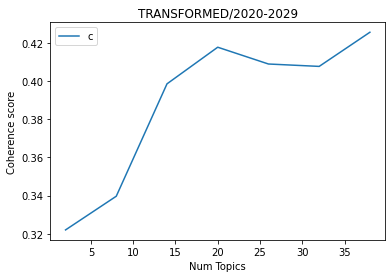

Num Topics = 2  has Coherence Value of 0.322
Num Topics = 8  has Coherence Value of 0.3397
Num Topics = 14  has Coherence Value of 0.3985
Num Topics = 20  has Coherence Value of 0.4177
Num Topics = 26  has Coherence Value of 0.4089
Num Topics = 32  has Coherence Value of 0.4077
Num Topics = 38  has Coherence Value of 0.4256


In [8]:
for corpus_root in ['.,TRANSFORMED/2020-2029']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

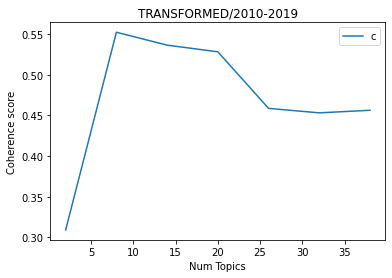

Num Topics = 2  has Coherence Value of 0.3091
Num Topics = 8  has Coherence Value of 0.5523
Num Topics = 14  has Coherence Value of 0.5364
Num Topics = 20  has Coherence Value of 0.5282
Num Topics = 26  has Coherence Value of 0.4586
Num Topics = 32  has Coherence Value of 0.4531
Num Topics = 38  has Coherence Value of 0.4563


In [10]:
for corpus_root in ['TRANSFORMED/2010-2019']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

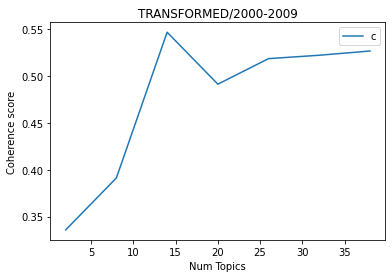

Num Topics = 2  has Coherence Value of 0.3358
Num Topics = 8  has Coherence Value of 0.3913
Num Topics = 14  has Coherence Value of 0.5471
Num Topics = 20  has Coherence Value of 0.4916
Num Topics = 26  has Coherence Value of 0.5189
Num Topics = 32  has Coherence Value of 0.5225
Num Topics = 38  has Coherence Value of 0.527


In [6]:
for corpus_root in ['TRANSFORMED/2000-2009']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

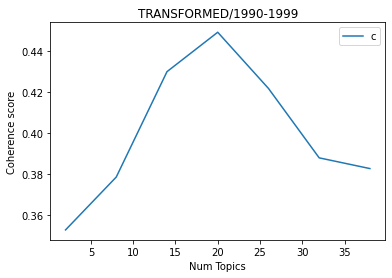

Num Topics = 2  has Coherence Value of 0.3529
Num Topics = 8  has Coherence Value of 0.3786
Num Topics = 14  has Coherence Value of 0.4298
Num Topics = 20  has Coherence Value of 0.449
Num Topics = 26  has Coherence Value of 0.4216
Num Topics = 32  has Coherence Value of 0.3879
Num Topics = 38  has Coherence Value of 0.3827


In [7]:
for corpus_root in ['TRANSFORMED/1990-1999']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

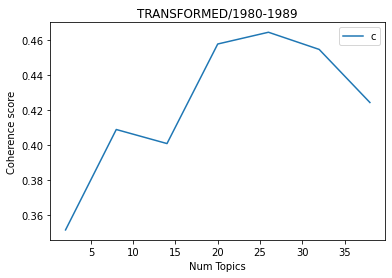

Num Topics = 2  has Coherence Value of 0.3516
Num Topics = 8  has Coherence Value of 0.409
Num Topics = 14  has Coherence Value of 0.401
Num Topics = 20  has Coherence Value of 0.458
Num Topics = 26  has Coherence Value of 0.4647
Num Topics = 32  has Coherence Value of 0.4549
Num Topics = 38  has Coherence Value of 0.4245


In [8]:
for corpus_root in ['TRANSFORMED/1980-1989']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

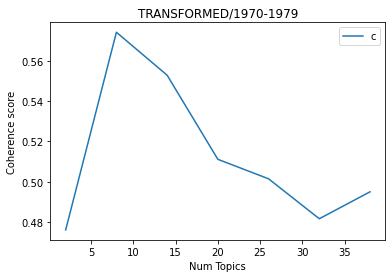

Num Topics = 2  has Coherence Value of 0.4762
Num Topics = 8  has Coherence Value of 0.5741
Num Topics = 14  has Coherence Value of 0.5528
Num Topics = 20  has Coherence Value of 0.5112
Num Topics = 26  has Coherence Value of 0.5015
Num Topics = 32  has Coherence Value of 0.4818
Num Topics = 38  has Coherence Value of 0.4951


In [6]:
for corpus_root in ['TRANSFORMED/1970-1979']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

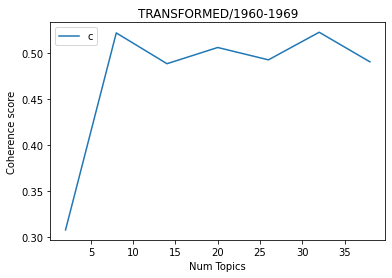

Num Topics = 2  has Coherence Value of 0.3075
Num Topics = 8  has Coherence Value of 0.5224
Num Topics = 14  has Coherence Value of 0.4888
Num Topics = 20  has Coherence Value of 0.5065
Num Topics = 26  has Coherence Value of 0.4931
Num Topics = 32  has Coherence Value of 0.5232
Num Topics = 38  has Coherence Value of 0.4909


In [7]:
for corpus_root in ['TRANSFORMED/1960-1969']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

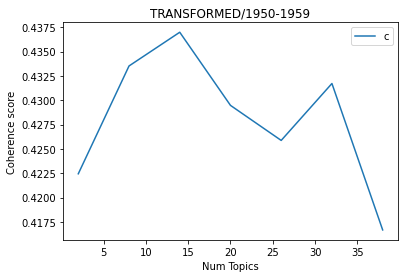

Num Topics = 2  has Coherence Value of 0.4224
Num Topics = 8  has Coherence Value of 0.4335
Num Topics = 14  has Coherence Value of 0.437
Num Topics = 20  has Coherence Value of 0.4295
Num Topics = 26  has Coherence Value of 0.4259
Num Topics = 32  has Coherence Value of 0.4317
Num Topics = 38  has Coherence Value of 0.4167


In [8]:
for corpus_root in ['TRANSFORMED/1950-1959']:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    # Can take a long time to run.
    
    # CHECK COHERENCE
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# Final Model

In [7]:
corpus_topics = {
  'TRANSFORMED/1950-1959':8,
  'TRANSFORMED/1960-1969':8,
  'TRANSFORMED/1970-1979':8,
  'TRANSFORMED/1980-1989':8,
  'TRANSFORMED/1990-1999':20,
  'TRANSFORMED/2000-2009':14,
  'TRANSFORMED/2010-2019':8,
  'TRANSFORMED/2020-2029':20
}

In [8]:
for corpus_root, topics_number in corpus_topics.items():
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Human readable format of corpus (term-frequency)
    # [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics_number, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    # Print the Keyword in the 10 topics
#     pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    
    # Compute Perplexity - a measure of how good the model is; Lower the better.
    perplexity = lda_model.log_perplexity(corpus)
#     print('\nPerplexity: ', perplexity)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)
    
    # Write the results to a file
    file_name = corpus_root.split("/")[1]
    with open(file_name+'.txt', 'w') as f:
        f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))
    
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, 'Results/LDA/'+file_name+'.html')
    print("Completed writing for {}.".format(file_name))
print("*"*20+"FINISHED"+"*"*20)

Completed writing for 1950-1959.
Completed writing for 1960-1969.
Completed writing for 1970-1979.
Completed writing for 1980-1989.
Completed writing for 1990-1999.
Completed writing for 2000-2009.


/common/home/jc2777/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed writing for 2010-2019.
Completed writing for 2020-2029.
********************FINISHED********************


# Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [24]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.6777,"union, industry, company, increase, worker, la...",metals industry speedsconversion average incre...
1,1,1,0.4405,"union, industry, company, increase, worker, la...",mining advances predicted 1951 exploration dev...
2,2,4,0.4378,"machine, company, automation, permission, repr...",engineers called vital defense assigning techn...
3,3,7,0.6666,"advertising, agency, woman, religious, young, ...",records socrate seldomheard satie plato dialog...
4,4,4,0.7555,"machine, company, automation, permission, repr...",dltna usual plane train anil bicycle years wee...
5,5,4,0.4642,"machine, company, automation, permission, repr...",madrid bargains american travelers shoppers pa...
6,6,4,0.6799,"machine, company, automation, permission, repr...",progress report grasses materials evaluated tr...
7,7,4,0.6639,"machine, company, automation, permission, repr...",equipment makers record output forecast based ...
8,8,7,0.2977,"advertising, agency, woman, religious, young, ...",gossip gathered rialto uewis 1ljnkf hoped amer...
9,9,7,0.2596,"advertising, agency, woman, religious, young, ...",dance training methods vocational school discu...


# Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 

So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                     axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9673,"union, industry, company, increase, worker, la...",rubber workers chicago united rubber workers g...
1,3,0.5430,"cargo, container, ship, international, maritim...",trade fairs scheduled united states abroad 196...
2,4,0.9697,"machine, company, automation, permission, repr...",offer devices spur automation electronic proce...
3,5,0.8641,"people, world, country, government, great, eco...",statement leaders communist parties meeting mo...
4,6,0.7341,"camera, school, student, teacher, light, sovie...",automatic cameras still movie items introduced...


The above has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

# Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1,"union, industry, company, increase, worker, la...",NaN,NaN
1,1,"union, industry, company, increase, worker, la...",430.0,0.4091
2,4,"machine, company, automation, permission, repr...",NaN,NaN
3,7,"advertising, agency, woman, religious, young, ...",2.0,0.0019
4,4,"machine, company, automation, permission, repr...",389.0,0.3701
...,...,...,...,...
1046,4,"machine, company, automation, permission, repr...",NaN,NaN
1047,1,"union, industry, company, increase, worker, la...",NaN,NaN
1048,1,"union, industry, company, increase, worker, la...",NaN,NaN
1049,4,"machine, company, automation, permission, repr...",NaN,NaN
